In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import wandb
import xarray as xr

from functools import partial
from dask.diagnostics import ProgressBar

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker

import seaborn as sns

from fme_diags.utils import (
    get_run_kwargs, get_wandb_path,
    load_config, load_global_time_mean_metrics,
    melt_training_steps, open_autoregressive_inference, 
    open_reference,
)

_ = xr.set_options(keep_attrs=True)

plt.rcParams['text.usetex'] = True

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jamesd (ai2cm). Use `wandb login --relogin` to force relogin


True

In [2]:
FULL_RETRAINING = "42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema"

EP_5 = "fv3gfs_noValidEMA_LpLoss_full_finetuning_lr3e-4_ep5-run00"
EP_10 = "fv3gfs_noValidEMA_LpLoss_full_finetuning_lr3e-4_ep10-run00"
EP_20 = "fv3gfs_noValidEMA_LpLoss_full_finetuning_lr3e-4_ep20-run00"

PARTIAL_FINETUNING="fv3gfs_finetune_noValidEMA_LpLoss_embed_block7_dec_lr3e-4_ep10-run00"

ZERO_SHOT = "fv3gfs_zero_shot-run00"
REF = "42-years-training-set-reference"

TRAIN_RUN_LABELS = {
    FULL_RETRAINING: "ACE-EAMv2",
    EP_5: "5-epoch finetuning",
    EP_10: "10-epoch finetuning",
    EP_20: "20-epoch finetuning",
}

INF_RUN_LABELS = {
    **TRAIN_RUN_LABELS,
    PARTIAL_FINETUNING: "10-epoch partial\nfinetuning",
    ZERO_SHOT: "FV3GFS-to-EAMv2 zero shot",
    REF: "EAMv2 noise floor",
}

ACE_FV3 = "fv3gfs_orig_norm-ic_0011-run00"
EP_5_FV3 = "fv3gfs_noValidEMA_LpLoss_full_finetuning_lr3e-4_ep5-ic_0011-norm-run00"
EP_10_FV3 = "fv3gfs_noValidEMA_LpLoss_full_finetuning_lr3e-4_ep10-ic_0011-norm-run00"
EP_20_FV3 = "fv3gfs_noValidEMA_LpLoss_full_finetuning_lr3e-4_ep20-ic_0011-norm-run00"

FV3GFS_INF_RUN_LABELS = {
    ACE_FV3: "ACE-FV3GFS",
    EP_5_FV3: "5-epoch finetuning",
    EP_10_FV3: "10-epoch finetuning",
    EP_20_FV3: "20-epoch finetuning",
}

# FV3GFS = "retrain-30e-rs1-10yr-ema"

In [3]:
config = load_config("./preds.yaml")
run_kwargs = get_run_kwargs(config, FULL_RETRAINING)
ds = open_autoregressive_inference(**run_kwargs)

In [4]:
OUTDIR = "figs/2024-04-25-full-finetuning"
os.makedirs(OUTDIR, exist_ok=True)

In [5]:
PRECIP = "surface_precipitation_rate"
PS = "PS"
OLR = "FLUT"
OSR = "top_of_atmos_upward_shortwave_flux"  
TWP_ADV = "tendency_of_total_water_path_due_to_advection"

PS_FACTOR = 0.01 
PS_UNITS = "hPa"

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

FLUX_UNITS = "W/m$^2$"

variables = config["variables"]
prognostic_vars = variables["labels"]["prognostic"]
diagnostic_vars = variables["labels"]["diagnostic"]
all_vars = {
    **prognostic_vars,
    **diagnostic_vars,
}

fv3gfs_variables = variables["fv3gfs"]
all_vars_fv3gfs = {
    **fv3gfs_variables["prognostic"],
    **fv3gfs_variables["diagnostic"],
}
fv3gfs_vars_dict = {v: all_vars[k] for k, v in all_vars_fv3gfs.items()}

wandb_inf_keys_stems = config["wandb_metrics"]["inference"]

all_units = {varname: ds[varname].units for varname in all_vars.keys()}
all_units[PRECIP] = PRECIP_UNITS
all_units[TWP_ADV] = PRECIP_UNITS
all_units[PS] = PS_UNITS

for k, v in all_units.items():
    if v == "W/m2":
        all_units[k] = FLUX_UNITS
        
all_units = pd.DataFrame.from_dict(all_units, orient="index", columns=["units"])

def rescale_variable(x, factor: float, units=None):
    x = x * factor
    if isinstance(x, xr.DataArray):
        x = x.assign_attrs(units=units)
    return x

UNIT_CONVERSIONS = {
    PRECIP: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    TWP_ADV: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    PS: partial(rescale_variable, factor=PS_FACTOR, units=PS_UNITS),
}

In [6]:
api = wandb.Api()

In [5]:
%%time

train_runs = {
    key: api.run(get_wandb_path(config, key, inference=False))
    for key in TRAIN_RUN_LABELS.keys()
}

train_rmse = {
    key: load_global_time_mean_metrics(
        wandb_run=run, 
        keys_stem=wandb_inf_keys_stems["rmse"],
        vars_dict=all_vars, 
        run_label=TRAIN_RUN_LABELS[key],
        # apply_funcs=UNIT_CONVERSIONS,
    )
    for key, run in train_runs.items()
}

train_rmse_df = pd.concat(train_rmse.values()).reindex(list(TRAIN_RUN_LABELS.values()), level=0)

CPU times: user 191 ms, sys: 30.4 ms, total: 221 ms
Wall time: 4.06 s


In [6]:
train_rmse_long = melt_training_steps(train_rmse_df)
train_rmse_long

value
run                 _step  variable                                                  
ACE-EAMv2           7665   PS                                             6935.797881
                    15330  PS                                              729.211596
                    22995  PS                                              403.160600
                    30660  PS                                              481.406569
                    38325  PS                                              368.398407
...                                                                               ...
20-epoch finetuning 122640 tendency_of_total_water_path_due_to_advection     0.000006
                    130305 tendency_of_total_water_path_due_to_advection     0.000009
                    137970 tendency_of_total_water_path_due_to_advection     0.000005
                    145635 tendency_of_total_water_path_due_to_advection     0.000007
                    153300 tendency_of_total_water_path_due_to_advection     0.000005

[3696 rows x 1 columns]

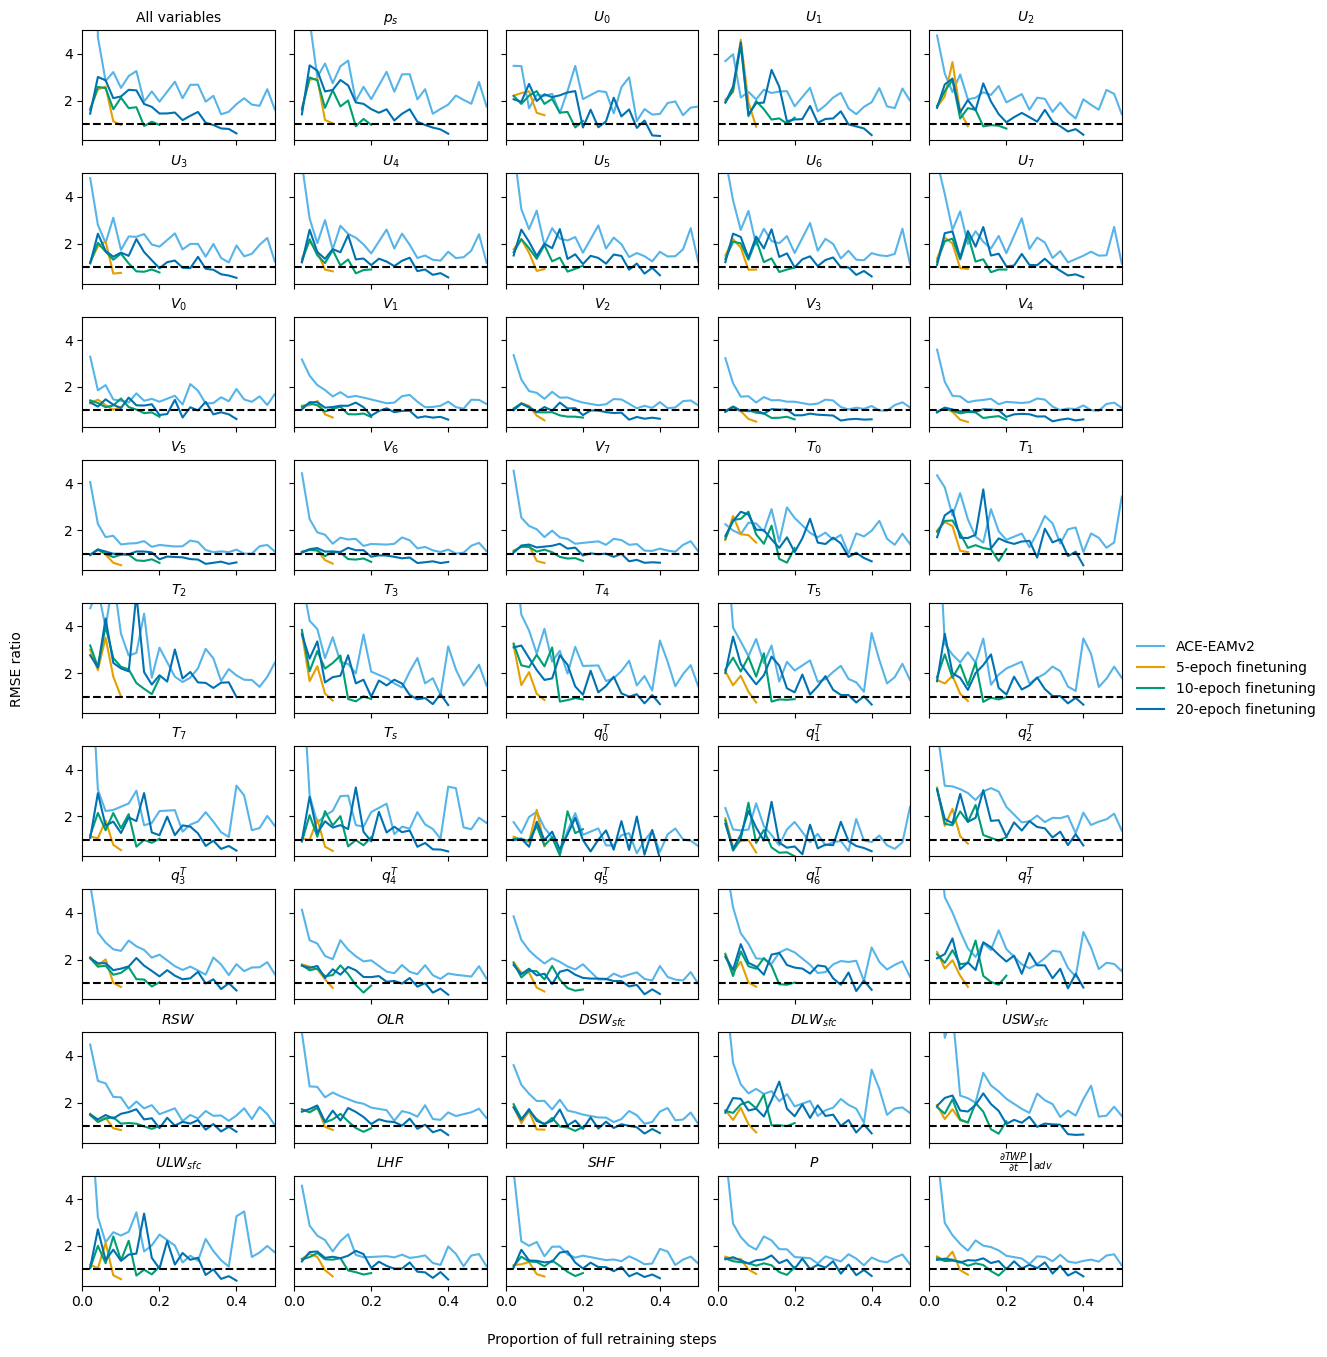

In [8]:
retrain_final_rmse = train_rmse_long.loc[
    train_rmse_long.index.get_level_values(0) == TRAIN_RUN_LABELS[FULL_RETRAINING]
].reset_index("_step").groupby("variable").last()

final_retrain_step = retrain_final_rmse["_step"].values[0]

retrain_final_rmse = retrain_final_rmse.drop("_step", axis=1)

df_retrain_final_ratio = []

for variable, title in [(None, "All variables")] + list(all_vars.items()):
    if variable is None:
        df = train_rmse_long
        df = df.groupby(["run", "_step"]).mean()
        df["variable"] = "All"
    else:
        df = train_rmse_long.reset_index("variable")
        df = df.loc[df["variable"] == variable]

    df = df.set_index("variable", append=True)
        
    if variable is None:
        denom = retrain_final_rmse.mean().item()
    else:
        denom = retrain_final_rmse.loc[variable].item()
        
    df = df.reset_index("_step")
    df["_step"] = df["_step"] / final_retrain_step
    df = df.set_index("_step", append=True)
    
    df["value"] = df["value"] / denom
    df["title"] = title
    df_retrain_final_ratio.append(df)
    
df_retrain_final_ratio = pd.concat(df_retrain_final_ratio)
df_retrain_final_ratio = df_retrain_final_ratio.reindex(list(TRAIN_RUN_LABELS.values()), level=0)

g = sns.FacetGrid(
    df_retrain_final_ratio, col="title", col_wrap=5,
    margin_titles=True, despine=False,
    height=1.5, aspect=1.5,
)

# Map the line plots to each subplot
g.map_dataframe(sns.lineplot, x='_step', y='value', hue="run")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "")

axs = g.axes.flatten()

for ax in axs:
    ax.axhline(y=1.0, color="k", linestyle="--")
    ax.set_xlim((0, 0.5))
    ax.set_ylim((0.3, 5))

# g.set(yscale="log")

g.figure.subplots_adjust(wspace=0.1, hspace=0.3)
g.fig.text(0.45, 0, "Proportion of full retraining steps", 
           horizontalalignment="center")
g.fig.text(0, 0.5, "RMSE ratio", 
           rotation="vertical", verticalalignment="center")

g.add_legend()

plt.show()

In [7]:
%%time

inf_runs = {
    key: api.run(get_wandb_path(config, key))
    for key in INF_RUN_LABELS.keys()
}

inf_rmse = {
    key: load_global_time_mean_metrics(
        wandb_run=run, 
        keys_stem=wandb_inf_keys_stems["rmse"],
        vars_dict=all_vars, 
        run_label=INF_RUN_LABELS[key],
        apply_funcs=UNIT_CONVERSIONS,
    )
    for key, run in inf_runs.items()
}

inf_rmse_df = pd.concat(inf_rmse.values())
inf_rmse_long = melt_training_steps(inf_rmse_df)

inf_rmse_long

CPU times: user 223 ms, sys: 32.2 ms, total: 256 ms
Wall time: 7.38 s


,,,value
run,_step,variable,
ACE-EAMv2,14596,PS,0.606210
5-epoch finetuning,14596,PS,0.889576
10-epoch finetuning,14596,PS,0.800354
20-epoch finetuning,14596,PS,0.711942
10-epoch partial\nfinetuning,14596,PS,0.663145
...,...,...,...
10-epoch finetuning,14596,tendency_of_total_water_path_due_to_advection,0.359276
20-epoch finetuning,14596,tendency_of_total_water_path_due_to_advection,0.344366
10-epoch partial\nfinetuning,14596,tendency_of_total_water_path_due_to_advection,0.419111


In [8]:
inf_df = inf_rmse_long.join(all_units, on="variable").join(
    pd.DataFrame.from_dict(all_vars, orient="index", columns=["title"]), 
    on="variable"
)
inf_df["title"] = inf_df["title"] + " [" + inf_df["units"] + "]"

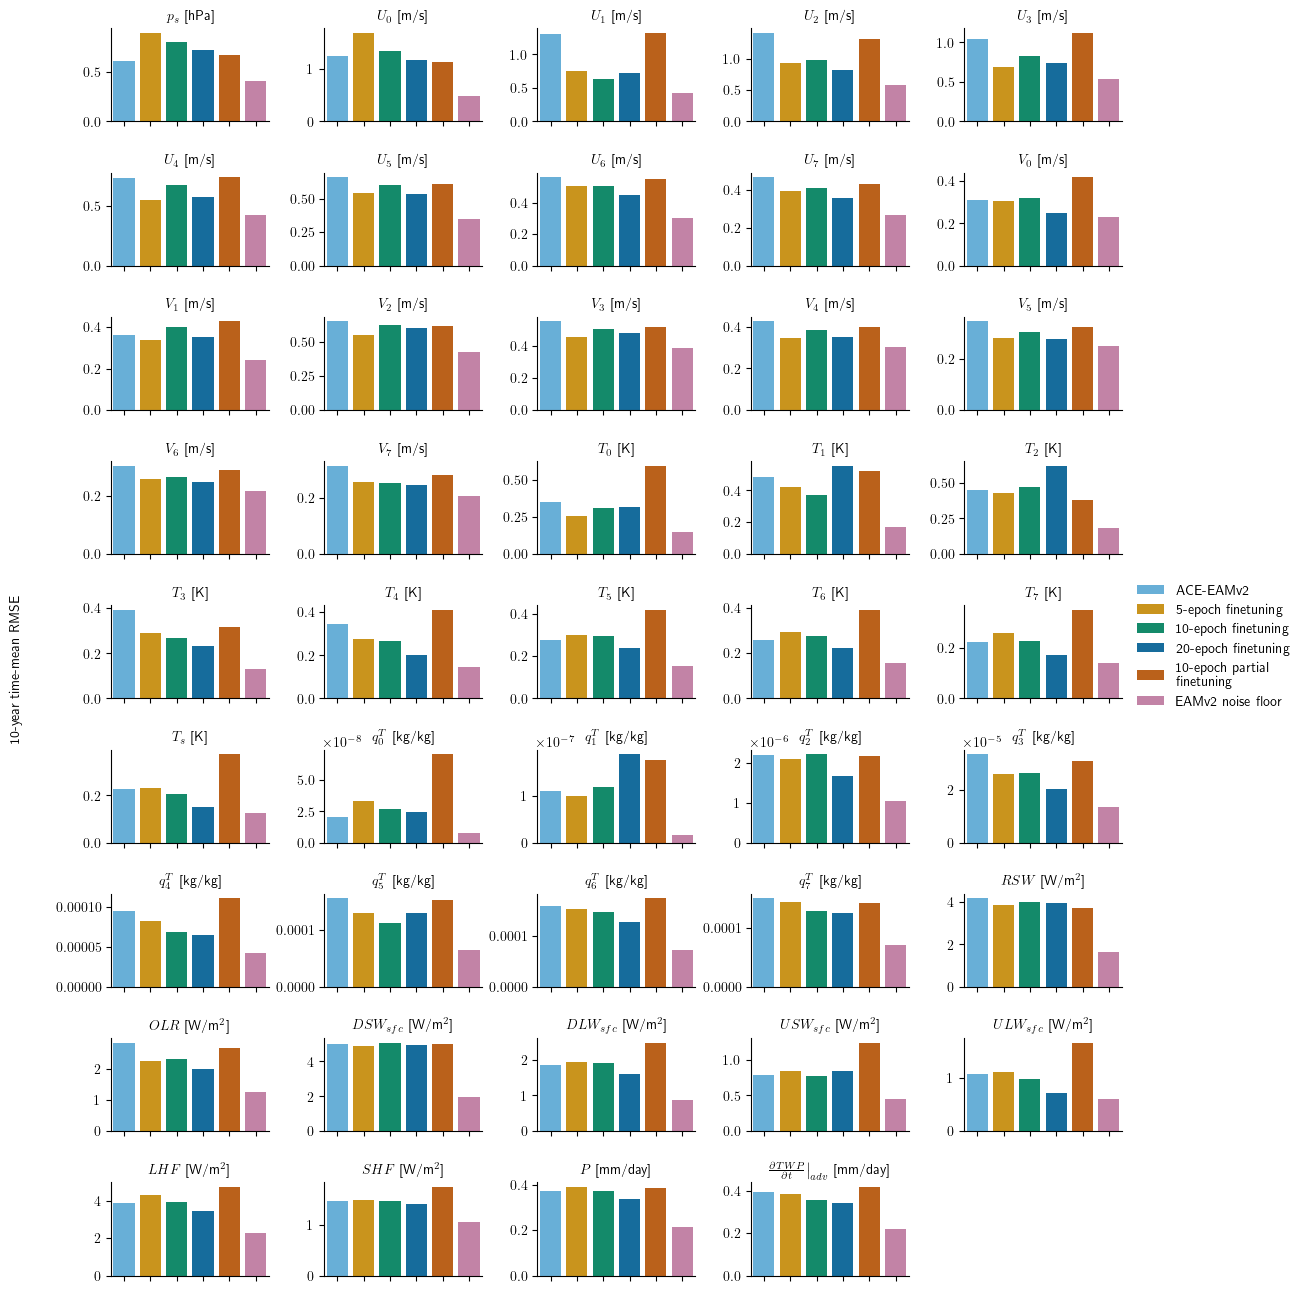

In [9]:
g = sns.catplot(
    inf_df.iloc[inf_df.index.get_level_values("run") != INF_RUN_LABELS[ZERO_SHOT]], 
    kind="bar", x="run", y="value", col="title", hue="run", col_wrap=5,
    height=1.5, aspect=1.5, sharey=False, legend="full",
)

g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}")

g.fig.text(0, 0.5, "10-year time-mean RMSE", 
           rotation="vertical", verticalalignment="center")

g._legend.set_title("")

g.set_xticklabels([])
g.figure.subplots_adjust(wspace=0.35, hspace=0.55)

plt.show()

In [10]:
REF_LABEL = INF_RUN_LABELS[REF]

inf_df_ref = inf_df.loc[REF_LABEL].reset_index("_step")
inf_df_ref = inf_df_ref.drop(
    ["_step", "units", "title"], 
    axis=1,
)

inf_df_norm = inf_df.reset_index("_step", drop=True)
inf_df_norm = inf_df_norm.join(inf_df_ref, on="variable", lsuffix="", rsuffix="_ref")
inf_df_norm["value_norm"] = inf_df_norm["value"] / inf_df_norm["value_ref"]

channel_mean_norm = inf_df_norm.groupby("run").mean(numeric_only=True)
channel_mean_norm["title"] = "All channels (normalized)"
channel_mean_norm["units"] = "unitless"
channel_mean_norm["variable"] = "All"
channel_mean_norm = channel_mean_norm.set_index("variable", append=True)

# set "value" to the normalized version for plotting
channel_mean_norm["value"] = channel_mean_norm["value_norm"]

inf_df_norm = pd.concat([inf_df_norm, channel_mean_norm])

inf_df_norm

,,value,units,title,value_ref,value_norm
run,variable,,,,,
ACE-EAMv2,PS,0.606210,hPa,$p_s$ [hPa],0.405713,1.494184
5-epoch finetuning,PS,0.889576,hPa,$p_s$ [hPa],0.405713,2.192622
10-epoch finetuning,PS,0.800354,hPa,$p_s$ [hPa],0.405713,1.972710
20-epoch finetuning,PS,0.711942,hPa,$p_s$ [hPa],0.405713,1.754792
10-epoch partial\nfinetuning,PS,0.663145,hPa,$p_s$ [hPa],0.405713,1.634517
...,...,...,...,...,...,...
20-epoch finetuning,All,1.925315,unitless,All channels (normalized),0.407355,1.925315
5-epoch finetuning,All,1.974916,unitless,All channels (normalized),0.407355,1.974916
ACE-EAMv2,All,2.120852,unitless,All channels (normalized),0.407355,2.120852


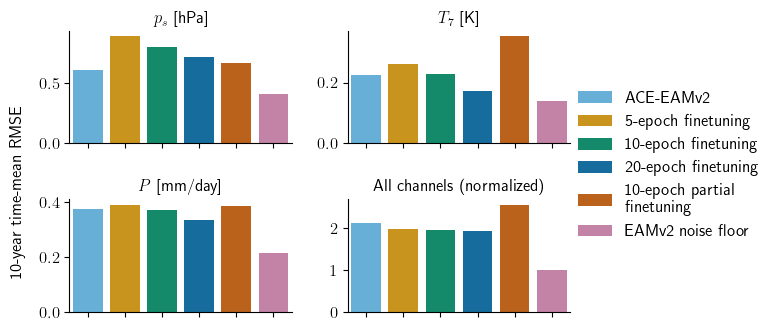

In [21]:
sns.set_context(rc={
    "font.size": 12,
})

vars_to_plot = ["All", "T_7", "surface_precipitation_rate", "PS"]

df_to_plot = inf_df_norm.loc[
    inf_df_norm.index.get_level_values("variable").isin(vars_to_plot)
]

df_to_plot = df_to_plot.loc[
    df_to_plot.index.get_level_values("run") != INF_RUN_LABELS[ZERO_SHOT]
]

g = sns.catplot(
    df_to_plot,
    kind="bar",
    x="run", y="value", col="title", hue="run", col_wrap=2,
    height=2, aspect=1.5, sharey=False, legend="full",
)

g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}")
g.fig.text(
    0.04, 0.5, "10-year time-mean RMSE", 
    rotation="vertical", verticalalignment="center"
)

g._legend.set_title("")

g.set_xticklabels([])
g.figure.subplots_adjust(wspace=0.25, hspace=0.5)

plt.show()

In [22]:
g.savefig(os.path.join(OUTDIR, "full_finetuning.pdf"), bbox_inches="tight")

In [61]:
%%time

inf_runs_fv3 = {
    key: api.run(get_wandb_path(config, key))
    for key in FV3GFS_INF_RUN_LABELS.keys()
}

inf_rmse_fv3 = {
    key: load_global_time_mean_metrics(
        wandb_run=run, 
        keys_stem=wandb_inf_keys_stems["rmse"],
        vars_dict=all_vars, 
        run_label=FV3GFS_INF_RUN_LABELS[key],
        apply_funcs=UNIT_CONVERSIONS,
    )
    for key, run in inf_runs_fv3.items()
}

inf_rmse_fv3_df = pd.concat(inf_rmse_fv3.values())
inf_rmse_fv3_long = melt_training_steps(inf_rmse_fv3_df)

inf_rmse_fv3_df

CPU times: user 38.8 ms, sys: 18.5 ms, total: 57.3 ms
Wall time: 944 ms


,,PS,U_0,U_1,U_2,U_3,U_4,U_5,U_6,U_7,V_0,...,top_of_atmos_upward_shortwave_flux,FLUT,FSDS,FLDS,surface_upward_shortwave_flux,surface_upward_longwave_flux,LHFLX,SHFLX,surface_precipitation_rate,tendency_of_total_water_path_due_to_advection
run,_step,,,,,,,,,,,,,,,,,,,,,
ACE-FV3GFS,14596,1.808828,1.710888,1.715136,2.533359,1.886607,1.245197,1.059534,0.980362,0.800601,0.484435,...,6.435694,3.158614,6.995996,2.950664,1.781235,2.347381,8.019211,3.229120,0.740310,0.707943
5-epoch finetuning,14596,14.621072,5.665852,5.407267,6.278041,4.221453,2.659274,2.427844,2.271773,1.850538,1.437940,...,16.903595,12.827410,23.195560,23.092911,10.102089,11.228965,32.204124,10.981621,2.259024,1.712812
10-epoch finetuning,14596,14.700057,7.504446,5.399600,5.931641,3.977004,2.653231,2.577206,2.369507,1.897591,1.431683,...,16.394743,12.451545,22.946947,23.691347,10.388535,10.825082,32.106373,11.069100,2.194088,1.652132
20-epoch finetuning,14596,14.787379,6.946623,5.436738,5.926711,4.092941,2.727531,2.615420,2.388302,1.924248,1.540969,...,16.118746,12.741355,22.947845,23.563442,10.363053,10.520896,32.528084,11.232071,2.217171,1.654754


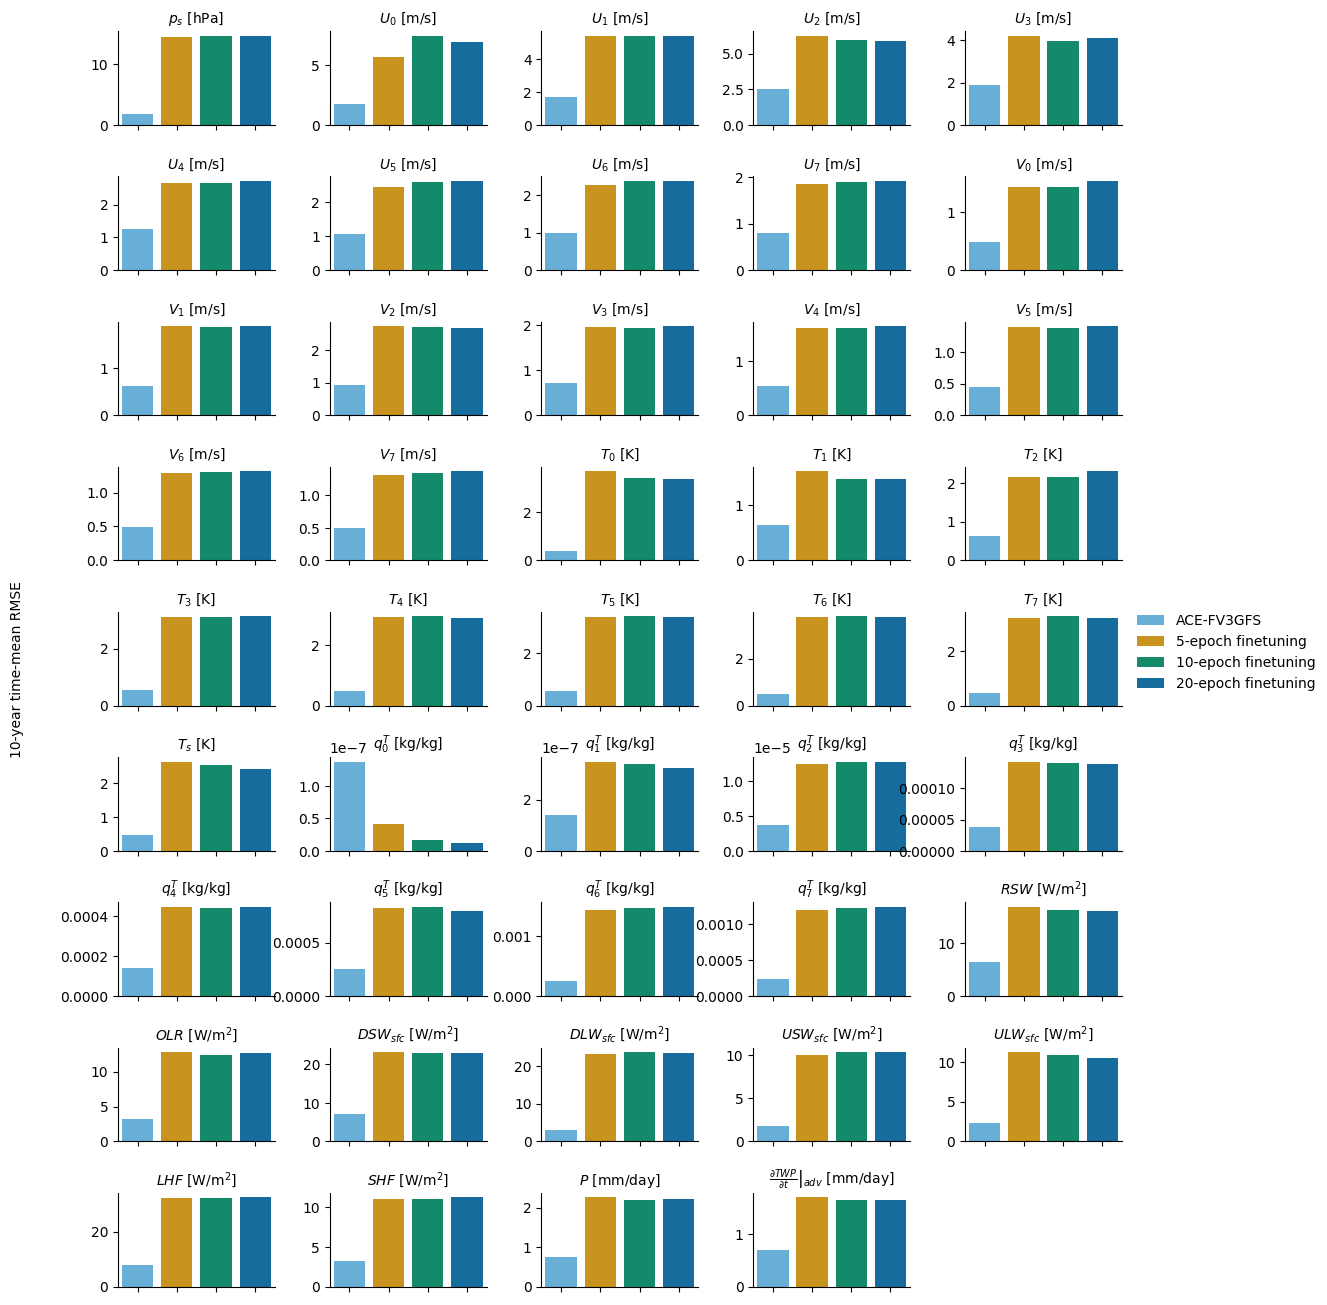

In [62]:
inf_df = inf_rmse_fv3_long.join(all_units, on="variable").join(
    pd.DataFrame.from_dict(all_vars, orient="index", columns=["title"]), 
    on="variable"
)
inf_df["title"] = inf_df["title"] + " [" + inf_df["units"] + "]"

g = sns.catplot(
    inf_df, kind="bar",
    x="run", y="value", col="title", hue="run", col_wrap=5,
    height=1.5, aspect=1.5, sharey=False, legend="full",
)

g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}")

g.fig.text(0, 0.5, "10-year time-mean RMSE", 
           rotation="vertical", verticalalignment="center")

g._legend.set_title("")

g.set_xticklabels([])
g.figure.subplots_adjust(wspace=0.35, hspace=0.55)

plt.show()